# **YouTube Sentiment Analysis**

In [33]:
from googleapiclient.discovery import build
import json
import requests
import time
import pandas as pd
import re
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

### Supressing all warnings

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Taking input and Splitting the video Id

In [3]:
#Test url with emoji's https://www.youtube.com/watch?v=las-iT6Vp6g
#Test url with links https://www.youtube.com/watch?v=Ou3v8-ngN6Y
#Test url with punctuations https://www.youtube.com/watch?v=tktKJWdLv10
#Test with most comments https://www.youtube.com/watch?v=gdZLi9oWNZg
url_input = "https://www.youtube.com/watch?v=rWcXunmleMk"
video_id_split =url_input.split('=')
video_id=video_id_split[1]

### Total number of comments

#### *Quota impact: A call to this method has a quota cost of 1 unit.*
#### *1 call returns 20 comments* 
#### *Daily quota limit = 10,000 unit (Daily quotas reset at midnight Pacific Time (PT) = 12.45 PM NPT)* 
#### *Total number of comments that can be retrived in a day ~ 10,000 * 20 = 200,000* 
#### *Approximately < 195,000 comment's can be retrived in a day*


In [4]:
api_key = ''
url = 'https://www.googleapis.com/youtube/v3/videos?id='+video_id+'&key='+api_key+'&part=snippet,contentDetails,statistics,status'
response_info=requests.get(url).json()
comments=[]
for comment_count in response_info['items']:
 comments.append(comment_count['statistics'])
for val in comments:
  total = int(val['commentCount'])
print(total)
if(total>=195000):
  print("Cannot retrive more than 195,000 comments")

2580


### ***(Additional)*** For viewing the number of dislikes in the video

In [5]:
url_api = "https://returnyoutubedislikeapi.com/votes?videoId="+video_id
response_API=requests.get(url_api)
data = response_API.text
parse_json = json.loads(data)
number_dislikes = parse_json['dislikes']
print(number_dislikes)

2714


### Storing all the comments in a list


In [6]:
def getAllTopLevelCommentReplies(topCommentId, replies, token): 
    replies_response=youtube.comments().list(part='snippet',
                                               maxResults=100,
                                               parentId=topCommentId,
                                               pageToken=token).execute()

    for item in replies_response['items']:
        replies.append(item['snippet']['textDisplay'])
    if "nextPageToken" in replies_response: 
      return getAllTopLevelCommentReplies(topCommentId, replies, replies_response['nextPageToken'])
    else:
      return replies
      
def get_comments(youtube, video_id, comments=[], token=''):
  totalReplyCount = 0
  replies=[]

  video_response=youtube.commentThreads().list(part='snippet',
                                               videoId=video_id,
                                               pageToken=token).execute()
  for item in video_response['items']:
            comment = item['snippet']['topLevelComment']
            text = comment['snippet']['textDisplay']
            totalReplyCount = item['snippet']['totalReplyCount']
            if (totalReplyCount > 0): 
               comments.extend(getAllTopLevelCommentReplies(comment['id'], replies, None)) 
            else: 
               comments.append(text)
            replies = []

  if "nextPageToken" in video_response: 
        return get_comments(youtube, video_id, comments, video_response['nextPageToken'])
  else:
        return comments

youtube = build('youtube', 'v3',developerKey=api_key)
comments = get_comments(youtube,video_id)
print(len(comments))

2467


### Converting the list to dataframe


In [7]:
df_from_yt = pd.DataFrame(comments,columns=['Comments'])
print(df_from_yt)

                                               Comments
0                                                   Hii
1     <a href="https://www.youtube.com/watch?v=rWcXu...
2                        That Russia Ukraine joke 200iq
3                                                naveed
4     <a href="https://www.youtube.com/watch?v=rWcXu...
...                                                 ...
2462                                               Same
2463                                             Agreed
2464  I Respect Everyone who were involved in this ,...
2465                                             Second
2466                               I&#39;ll support you

[2467 rows x 1 columns]


## Data Cleaning


### Removing all the emoji's from the dataframe


In [8]:
df_from_yt = df_from_yt.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
df_from_yt

,Comments
0,Hii
1,"<a href=""https://www.youtube.com/watch?v=rWcXu..."
2,That Russia Ukraine joke 200iq
3,naveed
4,"<a href=""https://www.youtube.com/watch?v=rWcXu..."
...,...
2462,Same
2463,Agreed
2464,"I Respect Everyone who were involved in this ,..."
2465,Second


### Removing all the url's from the data frame

In [9]:
df_from_yt['Comments'] = df_from_yt['Comments'].apply(lambda x: re.split('<a href="https:\/\/.*', str(x))[0])
df_from_yt

,Comments
0,Hii
1,
2,That Russia Ukraine joke 200iq
3,naveed
4,
...,...
2462,Same
2463,Agreed
2464,"I Respect Everyone who were involved in this ,..."
2465,Second


### Removing all special characters

In [10]:
def process_content(content):
    return " ".join(re.findall("[A-Za-z]+",content))

df_from_yt['Comments'] = df_from_yt['Comments'].apply(process_content)
df_from_yt

,Comments
0,Hii
1,
2,That Russia Ukraine joke iq
3,naveed
4,
...,...
2462,Same
2463,Agreed
2464,I Respect Everyone who were involved in this S...
2465,Second


### Converting to lower case

In [11]:
df_from_yt['Comments'] = df_from_yt['Comments'].str.lower()
df_from_yt

,Comments
0,hii
1,
2,that russia ukraine joke iq
3,naveed
4,
...,...
2462,same
2463,agreed
2464,i respect everyone who were involved in this s...
2465,second


### Removing empty rows

In [12]:
df_from_yt['Comments'].replace('', np.nan, inplace=True)
df_from_yt.dropna()

,Comments
0,hii
2,that russia ukraine joke iq
3,naveed
5,rpi kehta hai
6,bhai ni chahiye ka hi bata do
...,...
2462,same
2463,agreed
2464,i respect everyone who were involved in this s...
2465,second


## **Training and Testing Model for Spam Detection**

### Importing dataset's and storing into a dataframe 

In [13]:
train_data=[]
data_files = ['/content/drive/MyDrive/Youtube-Sentiment-Analysis/Youtube01-Psy.csv',
              '/content/drive/MyDrive/Youtube-Sentiment-Analysis/Youtube02-KatyPerry.csv',
              '/content/drive/MyDrive/Youtube-Sentiment-Analysis/Youtube03-LMFAO.csv',
              '/content/drive/MyDrive/Youtube-Sentiment-Analysis/Youtube04-Eminem.csv',
              '/content/drive/MyDrive/Youtube-Sentiment-Analysis/Youtube05-Shakira.csv']
for file in data_files:
    data = pd.read_csv(file)
    train_data.append(data)
train_data = pd.concat(train_data)

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 369
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1956 non-null   object
 1   AUTHOR      1956 non-null   object
 2   DATE        1711 non-null   object
 3   CONTENT     1956 non-null   object
 4   CLASS       1956 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 91.7+ KB


## Data Cleaning

### Dropping the columns that isn't required

In [15]:
def drop_fectures(features,data):
    data.drop(features,axis=1,inplace=True)

drop_fectures(['COMMENT_ID','AUTHOR','DATE'],train_data)

### Removing all special characters

In [16]:
def process_content(content):
    return " ".join(re.findall("[A-Za-z]+",content.lower()))
  
train_data['CONTENT'] = train_data['CONTENT'].apply(process_content)
train_data

,CONTENT,CLASS
0,huh anyway check out this you tube channel kob...,1
1,hey guys check out my new channel and our firs...,1
2,just for test i have to say murdev com,1
3,me shaking my sexy ass on my channel enjoy,1
4,watch v vtarggvgtwq check this out,1
...,...,...
365,i love this song because we sing it at camp al...,0
366,i love this song for two reasons it is about a...,0
367,wow,0
368,shakira u are so wiredo,0


## Splitting data into *train* and *test* sets

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
                                    train_data['CONTENT'],
                                   train_data['CLASS'],
                                   test_size=0.2,
                                   random_state=57)

### Using [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for converting  text to numerical data. 

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(stop_words='english')
x_train_counts = count_vect.fit_transform(x_train)
x_train_counts.shape

(1564, 3345)

## Model Selection 


### Blank list for **Comparison**

In [19]:
Accuracy = []
Algorithm = []
from sklearn.metrics import accuracy_score

## Linear Regression

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer
tranformer = TfidfTransformer()
x_train_tfidf = tranformer.fit_transform(x_train_counts)
x_train_tfidf.shape
x_test_counts = count_vect.transform(x_test)
x_test_tfidf = tranformer.transform(x_test_counts)

In [21]:
from sklearn.linear_model import LinearRegression
Algorithm.append('LinearRegression (ML)')
regressor = LinearRegression()
regressor.fit(x_train_tfidf, y_train)
predicted = regressor.predict(x_test_tfidf)

### Calculating Accuracy

In [22]:
a = accuracy_score(y_test,predicted.round())*100
Accuracy.append("%.2f" % a)

## XGBoost or Extreme Gradient Boost Regression

In [23]:
import xgboost as xgb
Algorithm.append('XGB Regressor (ML)')
regressor = xgb.XGBRegressor()
regressor.fit(x_train_tfidf, y_train)
predicted = regressor.predict(x_test_tfidf)

[14:33:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### Accuracy


In [24]:
a = accuracy_score(y_test,predicted.round())*100
Accuracy.append("%.2f" % a)

##  Random Forest Regression

In [25]:
from sklearn.ensemble import RandomForestRegressor
Algorithm.append('RandomForestRegressor (ML)')
regressor = RandomForestRegressor() 
regressor.fit(x_train_tfidf, y_train)
predicted = regressor.predict(x_test_tfidf)

### Accuracy

In [26]:
a = accuracy_score(y_test,predicted.round())*100
Accuracy.append("%.2f" % a)

## Keras **(Deep Learning)**

### Importing

In [27]:
import tensorflow as tf
import tensorflow_hub as hub
import keras 

# helps in text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# helps in model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

### Building the model

In [28]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________
None


## Training the model

In [29]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train,
         y_train,
         epochs=40,
         batch_size=512,
         validation_data=(x_test, y_test),
         verbose=1,
         callbacks=[early_stop]
)

Epoch 1/40
4/4 [==============================] - 3s 314ms/step - loss: 0.7371 - accuracy: 0.4808 - val_loss: 0.6807 - val_accuracy: 0.5765
Epoch 2/40
4/4 [==============================] - 1s 300ms/step - loss: 0.6647 - accuracy: 0.6317 - val_loss: 0.6414 - val_accuracy: 0.7041
Epoch 3/40
4/4 [==============================] - 1s 255ms/step - loss: 0.6229 - accuracy: 0.7468 - val_loss: 0.6145 - val_accuracy: 0.7653
Epoch 4/40
4/4 [==============================] - 1s 255ms/step - loss: 0.5905 - accuracy: 0.8043 - val_loss: 0.5884 - val_accuracy: 0.8138
Epoch 5/40
4/4 [==============================] - 1s 254ms/step - loss: 0.5597 - accuracy: 0.8593 - val_loss: 0.5629 - val_accuracy: 0.8444
Epoch 6/40
4/4 [==============================] - 1s 253ms/step - loss: 0.5303 - accuracy: 0.8983 - val_loss: 0.5403 - val_accuracy: 0.8622
Epoch 7/40
4/4 [==============================] - 1s 257ms/step - loss: 0.5017 - accuracy: 0.9175 - val_loss: 0.5170 - val_accuracy: 0.8827
Epoch 8/40
4/4 [====

## Testing the model

In [30]:
predicted = model.predict(x_test)

Algorithm.append('Keras (DL)')

### Accuracy

In [31]:
a = accuracy_score(y_test,predicted.round())*100
Accuracy.append("%.2f" % a)

## Creating a comparison dataframe


In [32]:
comparison = pd.DataFrame(list(zip(Algorithm, Accuracy)), columns = ['Algorithm', 'Accuracy'])
comparison

,Algorithm,Accuracy
0,LinearRegression (ML),86.99
1,XGB Regressor (ML),90.82
2,RandomForestRegressor (ML),94.39
3,Keras (DL),90.82


## **Training and Testing Model for Positive/Negative Comments**

### Importing Dataset 

In [56]:
comments=pd.read_csv('/content/drive/MyDrive/Youtube-Sentiment-Analysis/GBcomments.csv',error_bad_lines=False)
comments.head()

b'Skipping line 113225: expected 4 fields, saw 5\n'
b'Skipping line 158379: expected 4 fields, saw 7\nSkipping line 241590: expected 4 fields, saw 5\nSkipping line 245637: expected 4 fields, saw 7\n'
b'Skipping line 521402: expected 4 fields, saw 5\n'


,video_id,comment_text,likes,replies
0,jt2OHQh0HoQ,It's more accurate to call it the M+ (1000) be...,0,0
1,jt2OHQh0HoQ,To be there with a samsung phone\n😂😂😂,1,0
2,jt2OHQh0HoQ,"Thank gosh, a place I can watch it without hav...",0,0
3,jt2OHQh0HoQ,What happened to the home button on the iPhone...,0,0
4,jt2OHQh0HoQ,Power is the disease. Care is the cure. Keep...,0,0


## **Natural Language Processing (NLP)**

In [58]:
from textblob import TextBlob
TextBlob('Its more accurate to call it the M+ (1000) be..').sentiment.polarity

0.45000000000000007

In [59]:
comments.dropna(inplace=True)

### Creating a list that will contain polarity of the Comments

In [60]:
polarity=[] 

for i in comments['comment_text']:
    polarity.append(TextBlob(i).sentiment.polarity)
  
comments['polarity']=polarity

comments.head()

,video_id,comment_text,likes,replies,polarity
0,jt2OHQh0HoQ,It's more accurate to call it the M+ (1000) be...,0,0,0.45
1,jt2OHQh0HoQ,To be there with a samsung phone\n😂😂😂,1,0,0.00
2,jt2OHQh0HoQ,"Thank gosh, a place I can watch it without hav...",0,0,0.00
3,jt2OHQh0HoQ,What happened to the home button on the iPhone...,0,0,0.00
4,jt2OHQh0HoQ,Power is the disease. Care is the cure. Keep...,0,0,1.00


## EDA for positive sentences

In [62]:
comments_positive=comments[comments['polarity']==1]
comments.head()

,video_id,comment_text,likes,replies,polarity
0,jt2OHQh0HoQ,It's more accurate to call it the M+ (1000) be...,0,0,0.45
1,jt2OHQh0HoQ,To be there with a samsung phone\n😂😂😂,1,0,0.00
2,jt2OHQh0HoQ,"Thank gosh, a place I can watch it without hav...",0,0,0.00
3,jt2OHQh0HoQ,What happened to the home button on the iPhone...,0,0,0.00
4,jt2OHQh0HoQ,Power is the disease. Care is the cure. Keep...,0,0,1.00


In [63]:
from wordcloud import WordCloud,STOPWORDS

stopwords=set(STOPWORDS)

In [64]:
total_comments=' '.join(comments_positive['comment_text'])

In [65]:
wordcloud=WordCloud(width=1000,height=500,stopwords=stopwords).generate(total_comments)

(-0.5, 999.5, 499.5, -0.5)

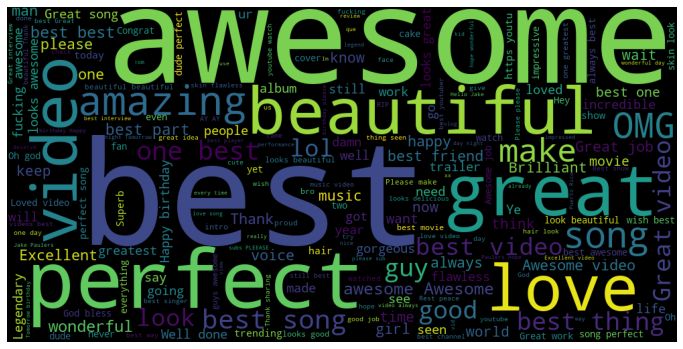

In [66]:
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis('off')

## EDA for negative sentences

In [67]:
comments_negative=comments[comments['polarity']==-1]

comments_negative.head()

,video_id,comment_text,likes,replies,polarity
1387,ql0Op1VcELw,boring,0,0,-1.0
1394,ql0Op1VcELw,0:22 **laughs at terrible pun**,1,1,-1.0
1530,-Ifnaxi2LQg,this is the worst thing i've heard. ever.,0,0,-1.0
1745,F2uJvwiSZAQ,People making jokes about 9/11 is truly disgus...,1,0,-1.0
1793,F2uJvwiSZAQ,Thats insane.,0,0,-1.0


In [68]:
total_comments=' '.join(comments_negative['comment_text'])

In [69]:
wordcloud=WordCloud(width=1000,height=500,stopwords=stopwords).generate(total_comments)

(-0.5, 999.5, 499.5, -0.5)

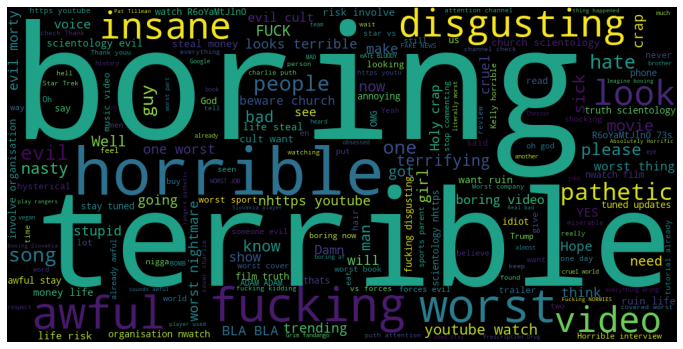

In [70]:
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis('off')